In [37]:
import pandas as pd

# Load the Excel file
file_path = 'LUMAX_Data.xlsx'
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names  # ['SKU1', 'SKU2', ..., 'SKU6']

# Load and clean all sheets
all_sheets = {}
for sheet in sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)
    
    # Clean column names
    df.columns = df.columns.str.strip()
    
    # Convert date column
    df['Date of Invoice'] = pd.to_datetime(df['Date of Invoice'])
    
    all_sheets[sheet] = df

# Check one to confirm
all_sheets['SKU1'].head()


,Material No.,Date of Invoice,Cat-III Desc,Cat-IV Desc,QTY,NET SALES
0,61004154,2022-05-20,2W BULB,2W HALOGEN BULB,7200,256372.70
1,61004154,2022-05-21,2W BULB,2W HALOGEN BULB,5200,185158.06
2,61004154,2022-05-22,2W BULB,2W HALOGEN BULB,10800,384559.05
3,61004154,2022-05-26,2W BULB,2W HALOGEN BULB,6800,241194.91
4,61004154,2022-05-31,2W BULB,2W HALOGEN BULB,4000,141879.36


In [38]:
# Dictionary to store monthly aggregated data
monthly_qty_per_sku = {}

for sheet, df in all_sheets.items():
    # Set Date of Invoice as index
    df.set_index('Date of Invoice', inplace=True)
    
    # Resample monthly and sum QTY
    monthly_qty = df['QTY'].resample('M').sum()
    
    # Store in the dictionary
    monthly_qty_per_sku[sheet] = monthly_qty

# Preview one SKU (e.g., SKU1)
monthly_qty_per_sku['SKU1'].head()


C:\Users\Ayushi\AppData\Local\Temp\ipykernel_9556\918298635.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_qty = df['QTY'].resample('M').sum()


Date of Invoice
2022-05-31     34000
2022-06-30     46599
2022-07-31     54599
2022-08-31     76713
2022-09-30    105795
Freq: ME, Name: QTY, dtype: int64

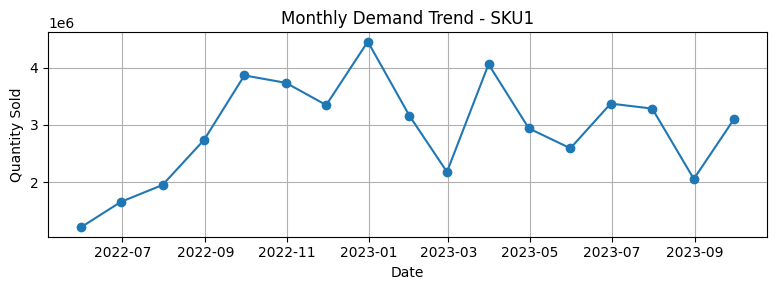

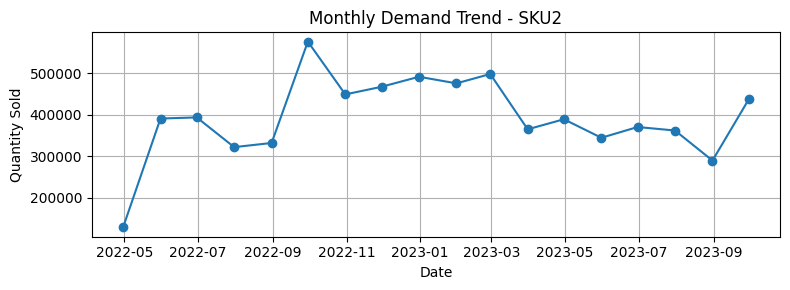

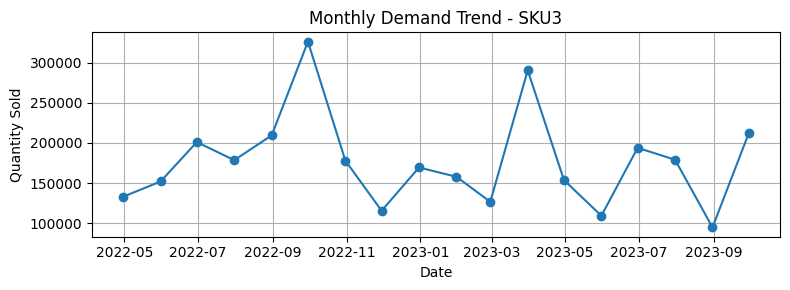

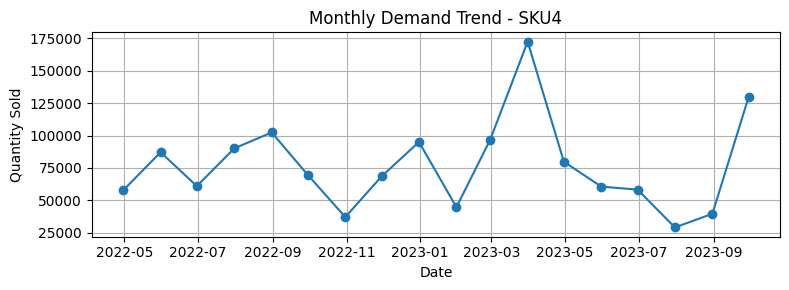

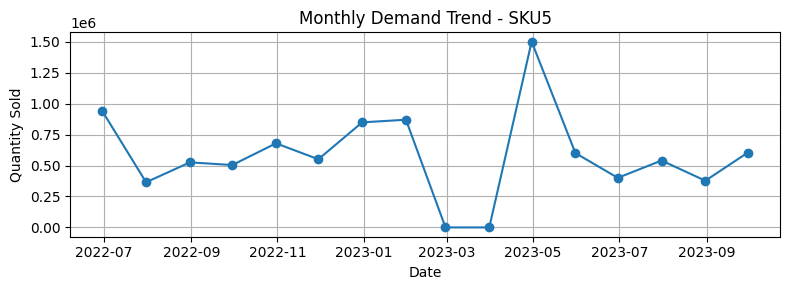

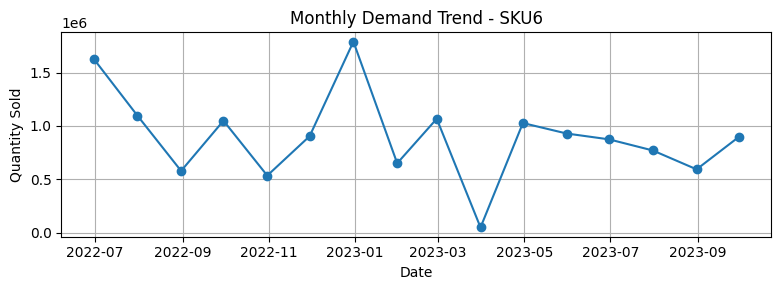

In [32]:
import matplotlib.pyplot as plt

# Plot trends for all SKUs
for sheet, monthly_qty in monthly_qty_per_sku.items():
    plt.figure(figsize=(8, 3))
    plt.plot(monthly_qty, marker='o', linestyle='-')
    plt.title(f'Monthly Demand Trend - {sheet}')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


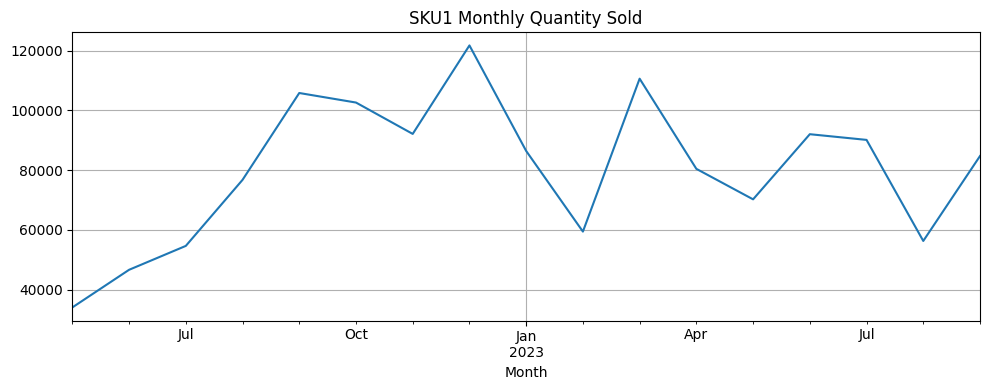

ADF Statistic: -2.6309884581129412
p-value: 0.08676020868722917
Series is Non-Stationary


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Load the dataset (replace with your actual CSV file if needed)
df = pd.read_excel('LUMAX_Data.xlsx', parse_dates=['Date of Invoice'])

# Filter for SKU1 (Material No. 61004154)
sku1_df = df[df['Material No.'] == 61004154]

# Convert to monthly time series
sku1_df['Month'] = sku1_df['Date of Invoice'].dt.to_period('M').dt.to_timestamp()
monthly_sales = sku1_df.groupby('Month')['NET SALES'].sum()

# Plot the time series
plt.figure(figsize=(10,4))
monthly_sales.plot(title='SKU1 Monthly NET SALES')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 1: ADF Test for Stationarity
result = adfuller(monthly_sales)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Series is", "Stationary" if result[1] < 0.05 else "Non-Stationary")



After Differencing:
ADF Statistic: -2.0559886851814615
p-value: 0.2625758273254662
Conclusion: Still Not Stationary 


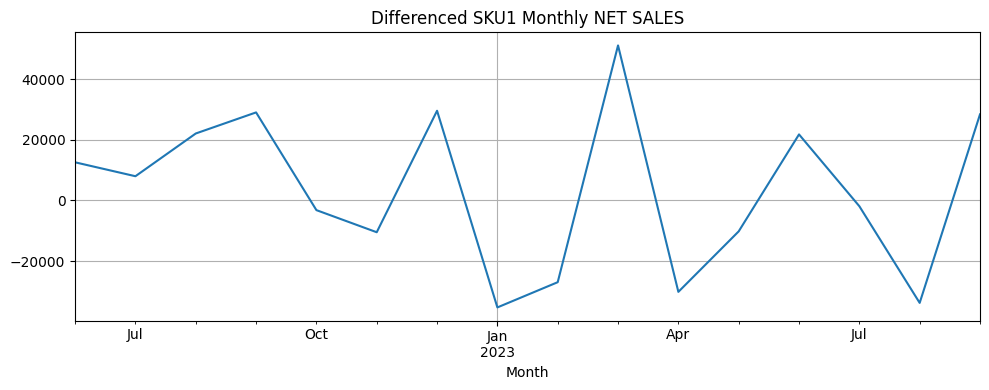

In [27]:
# 1st Order Differencing to make it stationary
diff_series = monthly_sales.diff().dropna()

# ADF Test again
from statsmodels.tsa.stattools import adfuller
result = adfuller(diff_series)
print("After Differencing:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Conclusion:", "Stationary" if result[1] < 0.05 else "Still Not Stationary ")

# Plot differenced series
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
diff_series.plot(title='Differenced SKU1 Monthly NET SALES')
plt.grid(True)
plt.tight_layout()
plt.show()


ADF Statistic (after 2nd order differencing): -4.462666726500701
p-value: 0.00022954759038465748
Conclusion: Stationary


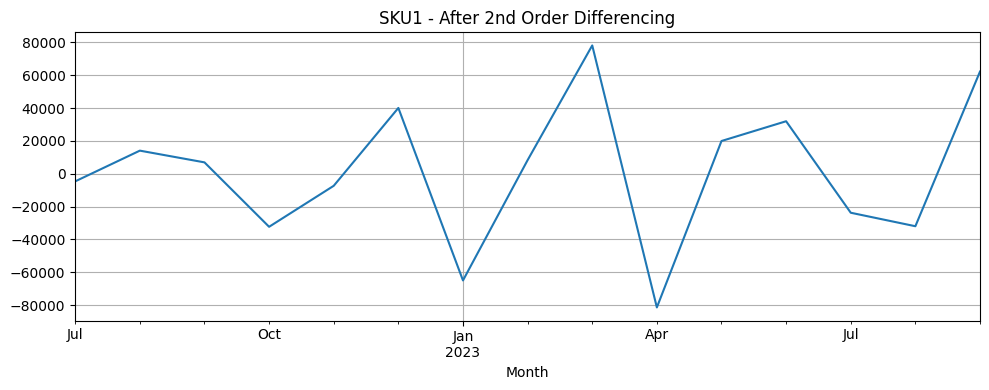

In [ ]:
# Apply 2nd order differencing
second_diff = monthly_sales.diff().diff().dropna()

# ADF test after 2nd differencing
from statsmodels.tsa.stattools import adfuller
result = adfuller(second_diff)
print("ADF Statistic (after 2nd order differencing):", result[0])
print("p-value:", result[1])
print("Conclusion:", "Stationary" if result[1] < 0.05 else "Still Not Stationary")

plt.figure(figsize=(10,4))
second_diff.plot(title="SKU1 - After 2nd Order Differencing")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#apply SARIMAX
model = sm.tsa.statespace.SARIMAX(monthly_sales,
                                  order=(1,2,1),              # d=2 here
                                  seasonal_order=(0,0,0,0),   # No seasonal component for now
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   QTY    No. Observations:                   17
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -152.882
Date:                Tue, 15 Apr 2025   AIC                            311.764
Time:                        17:32:31   BIC                            313.459
Sample:                    05-01-2022   HQIC                           311.415
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3913      0.624     -0.627      0.530      -1.614       0.831
ma.L1         -0.7916      0.360     -2.202      0.028      -1.496      -0.087
sigma2      1.468e+09    6.4e-11   2.29e+19      0.0

C:\Users\Ayushi\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Ayushi\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [30]:
model = sm.tsa.statespace.SARIMAX(monthly_sales,
                                  order=(0,2,1),  # Removed AR term
                                  seasonal_order=(0,0,0,0),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                   QTY    No. Observations:                   17
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -153.699
Date:                Tue, 15 Apr 2025   AIC                            311.398
Time:                        17:32:42   BIC                            312.528
Sample:                    05-01-2022   HQIC                           311.166
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8546      0.242     -3.538      0.000      -1.328      -0.381
sigma2      1.656e+09   1.54e-12   1.07e+21      0.000    1.66e+09    1.66e+09
Ljung-Box (L1) (Q):                   2.86   Jarque-

C:\Users\Ayushi\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Ayushi\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


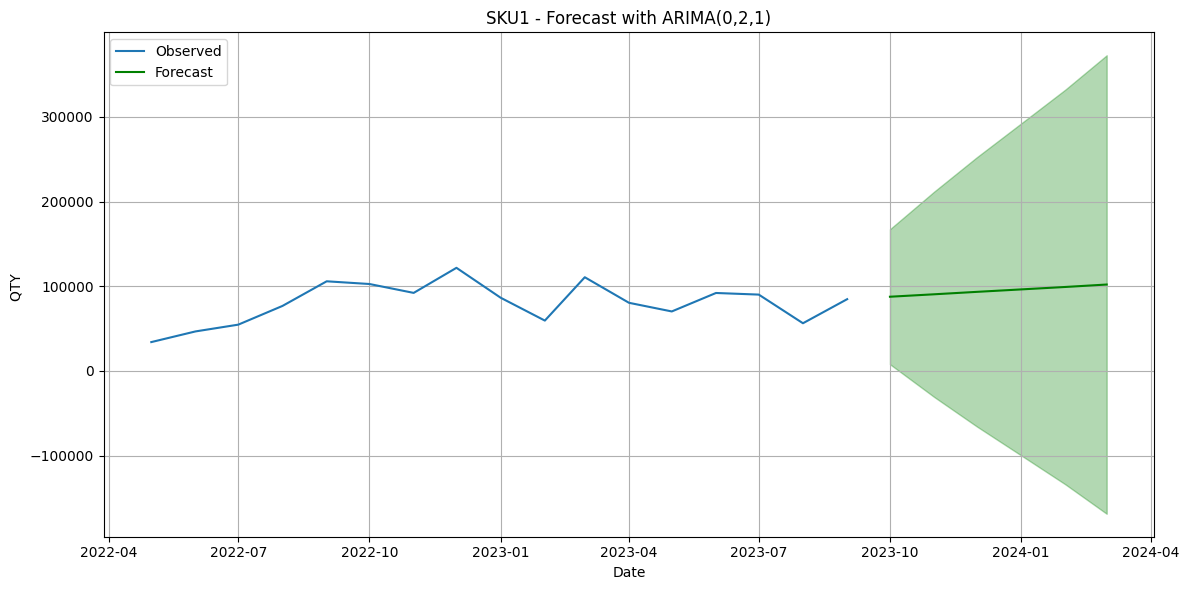

In [ ]:
# Forecast next 6 months
forecast = results.get_forecast(steps=6)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_index = pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(months=1),
                               periods=6, freq='MS')

# Plot forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(monthly_sales.index, monthly_sales, label='Observed')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color='green', alpha=0.3)
plt.title("SKU1 - Forecast with ARIMA(0,2,1)")
plt.xlabel("Date")
plt.ylabel("NET SALES")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


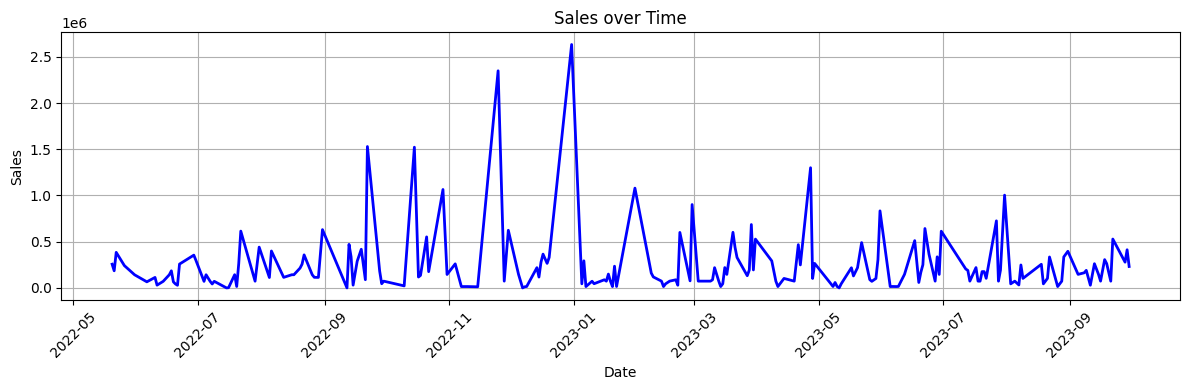

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_dataset.csv' with your actual dataset file path
df = pd.read_excel('LUMAX_Data.xlsx')

# Ensure that the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date of Invoice'])

# Plotting the graph
plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['NET SALES'], color='b', linestyle='-', linewidth=2, markersize=8)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales over Time')
plt.grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()